# LIME for Text Classification with Tensorflow Hub model

This notebook shows how you can use LIME to explain predictions for a text classification model. 

Start by installing some necessary libraries:

In [1]:
# !pip install nltk==3.7
# !pip install lime==0.2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e857b6fdfb3789fe79fd8c9cd1f0a61c2726d47269ea604fd460106497a1f432
  Stored in directory: /home/jupyter/.cache/pip/wheels/74/07/8a/d8e9b052b59c77421d03915d2a259b7ad9dcf6790264c7adf3
Successfully built lime


`nltk` is the Natural Langauge Tool Kit, a leading platform for building Python programs to work with human language data. Let's download the packages for punctuation and stop words.

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Cosine Similarity

Proximity measures in LIME use an exponential kernel on cosine distance between text instances.

In [3]:
# Program to measure the similarity between
# two sentences using cosine similarity.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

X ="If you like the original, you'll love this movie."
Y ="I liked the movie but the original was better."

# tokenization
X_list = word_tokenize(X)
Y_list = word_tokenize(Y)

# sw contains the list of stopwords
sw = stopwords.words('english')
l1 =[];l2 =[]

# remove stop words from the string
X_set = {w for w in X_list if not w in sw}
Y_set = {w for w in Y_list if not w in sw}

print(f'X_set: {X_set}')
print(f'Y_set: {Y_set}')

# form a set containing keywords of both strings
rvector = X_set.union(Y_set)
for w in rvector:
    if w in X_set: l1.append(1) # create a vector
    else: l1.append(0)
    if w in Y_set: l2.append(1)
    else: l2.append(0)
c = 0

# cosine formula
for i in range(len(rvector)):
    c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print("similarity: ", cosine)


X_set: {',', "'ll", '.', 'movie', 'original', 'love', 'like', 'If'}
Y_set: {'better', '.', 'movie', 'original', 'I', 'liked'}
similarity:  0.43301270189221935


## Train a model using Tensorflow Hub

We'll train a text classification model on the IMDB movie review dataset using Tensorflow Hub.

In [5]:
# !pip install tensorflow_hub==0.9.0

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

2022-10-31 19:59:38.955770: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [7]:
print(f'The tensorflow version is {tf.__version__}.')  # 2.3.4
print(f'The tensorflow hub version is {hub.__version__}.')  # 0.9.0

The tensorflow version is 2.3.4.
The tensorflow hub version is 0.9.0.


### Load the dataset.

In [8]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /home/jupyter/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteW3HHFX/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /home/jupyter/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteW3HHFX/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /home/jupyter/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteW3HHFX/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /home/jupyter/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2022-10-31 20:00:40.009969: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-10-31 20:00:40.043861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 20:00:40.045679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-10-31 20:00:40.045752: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-10-31 20:00:40.068247: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2022-10-31 20:00:40.085614: I tensorflow/stream_executor/platform/default/d

The label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Let's look at some training examples:

In [9]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))
train_examples_batch

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [10]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

2022-10-31 20:00:59.969514: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 192762400 exceeds 10% of free system memory.
2022-10-31 20:01:00.147634: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 192762400 exceeds 10% of free system memory.


### Build and train the model.

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10


2022-10-31 20:01:04.748758: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


30/30 [==============================] - 2s 73ms/step - loss: 0.6981 - accuracy: 0.5007 - val_loss: 0.6874 - val_accuracy: 0.4991
Epoch 2/10
30/30 [==============================] - 2s 69ms/step - loss: 0.6759 - accuracy: 0.5376 - val_loss: 0.6611 - val_accuracy: 0.6519
Epoch 3/10
30/30 [==============================] - 2s 69ms/step - loss: 0.6378 - accuracy: 0.7259 - val_loss: 0.6263 - val_accuracy: 0.7663
Epoch 4/10
30/30 [==============================] - 2s 68ms/step - loss: 0.5978 - accuracy: 0.8396 - val_loss: 0.5985 - val_accuracy: 0.8252
Epoch 5/10
30/30 [==============================] - 2s 69ms/step - loss: 0.5688 - accuracy: 0.8954 - val_loss: 0.5840 - val_accuracy: 0.8491
Epoch 6/10
30/30 [==============================] - 2s 70ms/step - loss: 0.5506 - accuracy: 0.9277 - val_loss: 0.5762 - val_accuracy: 0.8580
Epoch 7/10
30/30 [==============================] - 2s 71ms/step - loss: 0.5386 - accuracy: 0.9475 - val_loss: 0.5723 - val_accuracy: 0.8656
Epoch 8/10
30/30 [======

In [14]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 1s - loss: 0.5739 - accuracy: 0.8582
loss: 0.574
accuracy: 0.858


In [15]:
import shutil
OUTPUT_DIR = "./savedmodels"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)

EXPORT_PATH = os.path.join(OUTPUT_DIR, "imdb")
os.environ["EXPORT_PATH"] = EXPORT_PATH

shutil.rmtree(EXPORT_PATH, ignore_errors=True)

tf.keras.models.save_model(model, EXPORT_PATH)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-10-31 20:01:51.851160: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2022-10-31 20:01:52.259101: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 192762400 exceeds 10% of free system memory.
2022-10-31 20:01:52.407813: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 192762400 exceeds 10% of free system memory.
2022-10-31 20:01:52.543714: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 192762400 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./savedmodels/imdb/assets


INFO:tensorflow:Assets written to: ./savedmodels/imdb/assets


In [16]:
!ls ./savedmodels/imdb

assets	saved_model.pb	variables


## Explain predictions with LIME

Now that we have a trained Tensorflow model, let's use LIME to explain the model predictions.

In [17]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

In [18]:
imdb_model = tf.keras.models.load_model('savedmodels/imdb')

In [23]:
imdb_model.predict(["If you like the original, you will love this movie."])

array([[0.96929127]], dtype=float32)

Our model predicts statement `"If you like the original, you will love this movie."` as being a positive review with confidence 0.91.

For LIME we need to make a `predict_prob` function using our model. The `predict_prob` function should take the text and return the probabilities for the review being positive and negative as a tuple.

In [24]:
def predict_prob(texts):
    preds = imdb_model.predict(texts)
    return np.concatenate((1-preds, preds), axis=1)

Let's check it out:

In [25]:
predict_prob(["If you like the original, you will love this movie."])

array([[0.03070873, 0.96929127]], dtype=float32)

Now, we can use the LIME `explainer`.

In [26]:
exp = explainer.explain_instance(
    "If you like the original, you will love this movie.",
    predict_prob, labels=(0,1), num_features=10)

In [27]:
exp.available_labels()

[0, 1]

In [28]:
predicted_label = np.argmax(predict_prob(["If you like the original, you will love this movie."]))

In [29]:
exp.as_list(label=predicted_label)

[('you', 0.16492876815516036),
 ('love', 0.13560780626374777),
 ('will', 0.1080654485026677),
 ('original', 0.06671468204433234),
 ('the', 0.03504999976283606),
 ('If', -0.028866593304871645),
 ('like', -0.008465724934017566),
 ('this', -0.00803598166062189),
 ('movie', 0.005184885927641263)]

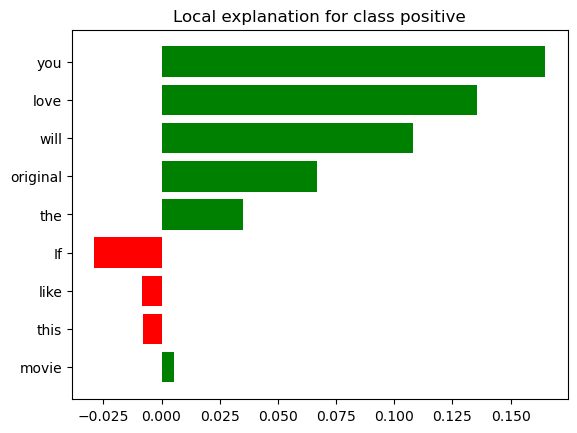

In [30]:
exp.as_pyplot_figure(label=predicted_label)
plt.show()

In [31]:
exp.show_in_notebook(labels=[predicted_label], show_predicted_value=True)

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License